<a href="https://colab.research.google.com/github/ispapadakis/cifar10/blob/master/CIFAR10_ResNet20_SuperConvergence_HyperOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Small Image Detection

Apply David Page Rules for Hyperparameter Optimization:
https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/

---

## Notebook Features

- Architecture: Resnet
- Data Augmentation: Cutout, Horizontal Flip, Shift
- "Super Convergence" Model Optimizer Schedule
- Iteratively improve model by rerunning key cells


<p> Based On: https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py
      


# Load Data and Libraries

In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, MaxPooling2D, Input, Flatten, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

Using TensorFlow backend.


In [0]:
# Model version
# Orig paper: version = 1 (ResNet v1)

version = 1
n = 3
depth = n * 6 + 2

num_classes = 10

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [3]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

170500096/170498071 [==============================] - 229s 1us/step


In [0]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
x_train_mean = np.mean(x_train, axis=(0,1,2))
x_train -= x_train_mean
x_test -= x_train_mean
x_train_std = np.std(x_train, axis=(0,1,2))
x_train /= x_train_std
x_test  /= x_train_std

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Model Architecture

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal',
                    kernel_regularizer=l2(1e-4))(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Train Model

In [9]:
hyper = {'lr':0.07,'rho':0.93,'alpha':1.5e-4,'augmentation_factor':4,'batch_size':128}

BATCHES_PER_EPOCH = hyper['augmentation_factor'] * x_train.shape[0] // hyper['batch_size']
BATCHES_PER_EPOCH

1562

## Optimizer Settings for Super Convergence

In [0]:
class SuperConvergence(keras.callbacks.Callback):
  def __init__(self, epoch_domain=[0, 15, 30, 40],
               lr_range = [0, 0.1, 0.005, 0], echo=False):
    super().__init__()
    self.epoch_domain = epoch_domain
    self.lr_range = lr_range
    self.lr_schedule  = lambda step: np.interp(step/BATCHES_PER_EPOCH, self.epoch_domain, self.lr_range)
    self.step = 0
    self.echo = echo
    
  def on_batch_begin(self, batch, logs=None):
    keras.backend.set_value(self.model.optimizer.lr, self.lr_schedule(self.step))
    self.step += 1
    
  def on_epoch_end(self, epoch, logs=None):
    if self.echo:
      lr = keras.backend.get_value(self.model.optimizer.lr)
      print('Learning Rate: {:.4f}'.format(lr))
  
  def epochs(self):
    return self.epoch_domain[-1]
  
  def __repr__(self):
    s = 'SuperConvergence('
    s += 'epoch_domain={}, '.format(self.epoch_domain)
    s += 'lr_range={}, '.format(self.lr_range)
    s += 'echo={})'.format(self.echo)
    return s

## Data Augmentation Generator

In [0]:
def fit_cutout(train_image, channels_last=True, cutout_pxl = 8):
    try:
        shape = train_image.shape
        if train_image.ndim != 3:
            raise Exception('Expecting 3D Image')
    except AttributeError:
        print('Expecting train_image input to be numpy array')
        raise

    if channels_last:
        img_h, img_w, img_c = shape
    else:
        img_c, img_h, img_w = shape
        
    sq_side_half = np.round(cutout_pxl / 2).astype('int')
    
    def preprocess(image):
      
        new_image = image.copy()
        
        h = np.random.randint(img_h)
        w = np.random.randint(img_w)
        
        h_lo = max(0,h-sq_side_half)
        h_hi = min(img_h,h+sq_side_half)
        
        w_lo = max(0,w-sq_side_half)
        w_hi = min(img_w,w+sq_side_half)
        
        value = np.random.uniform(0,1,(3,))

        if channels_last:
            new_image[h_lo:h_hi,w_lo:w_hi,:] = value[np.newaxis,np.newaxis,:]
        else:
            new_image[:,h_lo:h_hi,w_lo:w_hi] = value[:,np.newaxis,np.newaxis]
        return new_image
    return preprocess
  
cutout = fit_cutout(x_train[0])

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    #zoom_range=[0.8,1.4],
    #rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    #brightness_range=[.15,1.15], 
    #shear_range=15,
    #channel_shift_range=0.2,
    preprocessing_function = cutout,
    fill_mode='reflect'
    )

## Model Definition


In [0]:
def prep_model(lr,rho,alpha,**kwargs):
  keras.backend.clear_session()
  model = resnet_v1(input_shape=input_shape, depth=depth)
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.SGD(momentum=rho, nesterov=True, clipvalue=0.5),
                metrics=['accuracy'])

  for layer in model.layers:
      if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
          layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      if hasattr(layer, 'bias_regularizer') and layer.use_bias:
          layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))
          
  optim_sched = SuperConvergence(
      epoch_domain=[0, 10, 30, 35], lr_range = [0, lr, 0.005, 0]
  )
  
          
  return model, optim_sched

Instructions for updating:
Colocations handled automatically by placer.


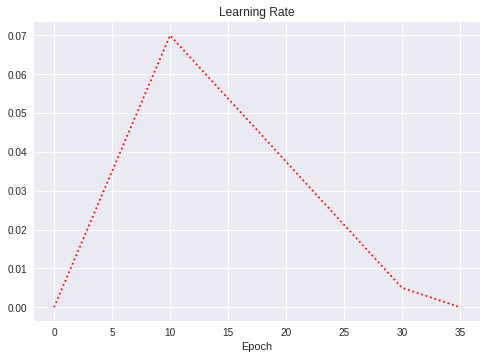

In [14]:
model, turbo = prep_model(**hyper)

plt.plot(turbo.epoch_domain,turbo.lr_range,'r:')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.show()

In [0]:
# save as JSON
pickle.dump( model.to_json(), open( model_type+"_model_json.pkl", "wb" ) )

## Fit Model

In [16]:
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=hyper['batch_size']),
    steps_per_epoch = BATCHES_PER_EPOCH,
    validation_data=(x_test, y_test),
    epochs=turbo.epochs(), verbose=2, 
    callbacks=[turbo]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/35
 - 163s - loss: 1.8027 - acc: 0.4086 - val_loss: 1.8251 - val_acc: 0.4570
Epoch 2/35
 - 155s - loss: 1.2069 - acc: 0.6243 - val_loss: 1.6380 - val_acc: 0.5466
Epoch 3/35
 - 157s - loss: 0.9629 - acc: 0.7148 - val_loss: 1.3027 - val_acc: 0.6500
Epoch 4/35
 - 156s - loss: 0.8290 - acc: 0.7637 - val_loss: 1.5593 - val_acc: 0.6065
Epoch 5/35
 - 155s - loss: 0.7590 - acc: 0.7904 - val_loss: 1.2209 - val_acc: 0.6923
Epoch 6/35
 - 156s - loss: 0.7145 - acc: 0.8101 - val_loss: 0.8150 - val_acc: 0.7917
Epoch 7/35
 - 157s - loss: 0.6919 - acc: 0.8202 - val_loss: 1.0521 - val_acc: 0.7386
Epoch 8/35
 - 158s - loss: 0.6826 - acc: 0.8270 - val_loss: 0.8619 - val_acc: 0.7740
Epoch 9/35
 - 158s - loss: 0.6773 - acc: 0.8330 - val_loss: 0.8204 - val_acc: 0.8029
Epoch 10/35
 - 157s - loss: 0.6791 - acc: 0.8376 - val_loss: 0.8666 - val_acc: 0.7849
Epoch 11/35
 - 156s - loss: 0.6745 - acc: 0.8416 - val_loss: 1.0315 - val_acc: 0.7541
Epoch 12/35
 - 

In [17]:
print('Parameters: ',hyper)
pd.DataFrame(hist.history).style.format('{:.4f}').bar(['acc','val_acc'],color='lightgreen').bar(['loss','val_loss'],color='lightblue')

Parameters:  {'lr': 0.07, 'rho': 0.93, 'alpha': 0.00015, 'augmentation_factor': 4, 'batch_size': 128}


,acc,loss,val_acc,val_loss
0,0.4086,1.8028,0.4570,1.8251
1,0.6242,1.2069,0.5466,1.6380
2,0.7148,0.9629,0.6500,1.3027
3,0.7637,0.8289,0.6065,1.5593
4,0.7905,0.7589,0.6923,1.2209
5,0.8102,0.7144,0.7917,0.8150
6,0.8203,0.6919,0.7386,1.0521
7,0.8270,0.6826,0.7740,0.8619
8,0.8331,0.6773,0.8029,0.8204
9,0.8376,0.6791,0.7849,0.8666


In [0]:
model.save_weights(model_type+'_weights_v0.h5')

# Hyperparameter *Optimization*

In [0]:
LR_POS, RHO_POS, ALPHA_POS = [0,1,2]

def get_params(exponent, base=1.5):
  lr = hyper['lr'] * base ** exponent[LR_POS]
  rho = 1 - (1-hyper['rho']) * base ** exponent[RHO_POS]
  alpha = hyper['alpha'] * base ** exponent[ALPHA_POS]
  return {'lr':lr,'rho':rho,'alpha':alpha}


def gen_combo(prior,v):
  while True:
    # diff order --> lambda, rho, alpha
    for diff_ in [(-1,0,0),(1,1,0),(-1,0,1)]:
      fmt = 'Prior: ({lr:.4f},{rho:.3f},{alpha:.5f})'
      print(fmt.format(**get_params(prior)), ' val_acc = {:.4f}\n'.format(v))
      new1 = tuple(x-d for x,d in zip(prior,diff_))
      v_new = (yield new1)
      if v_new > v:
        yield 'Improved'
        v = v_new
        prior = new1
      else:
        yield 'Not Improved'
        new2 = tuple(x+d for x,d in zip(prior,diff_))
        v_new = (yield new2)
        if v_new > v:
          yield 'Improved'
          v = v_new
          prior = new2
        else:
          yield 'Not Improved'

### Initialize Cycle

In [0]:
# Starting Point
curr = (0,0,0)
curr_opt = np.max(hist.history['val_acc'])

# Performance Record
perf = {curr:curr_opt}

In [0]:
# Iterator for Candidate Combinations
it = gen_combo(curr,perf[curr])

### Generate New Parameter Combination

In [22]:
curr2 = next(it)
print('Candidate: ({lr:.4f},{rho:.3f},{alpha:.5f})'.format(**get_params(curr2)) )

Prior: (0.0700,0.930,0.00015)  val_acc = 0.9269

Candidate: (0.1050,0.930,0.00015)


In [23]:
model, turbo = prep_model(**get_params(curr2))

hist2 = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=hyper['batch_size']),
    steps_per_epoch = BATCHES_PER_EPOCH,
    validation_data=(x_test, y_test),
    epochs=turbo.epochs(), verbose=2, 
    callbacks=[turbo]
)

Epoch 1/35
 - 158s - loss: 1.6814 - acc: 0.4509 - val_loss: 2.8142 - val_acc: 0.3389
Epoch 2/35
 - 154s - loss: 1.1214 - acc: 0.6575 - val_loss: 1.5190 - val_acc: 0.5796
Epoch 3/35
 - 154s - loss: 0.8948 - acc: 0.7416 - val_loss: 1.2439 - val_acc: 0.6708
Epoch 4/35
 - 148s - loss: 0.7926 - acc: 0.7807 - val_loss: 0.7757 - val_acc: 0.7859
Epoch 5/35
 - 151s - loss: 0.7380 - acc: 0.8029 - val_loss: 0.9404 - val_acc: 0.7462
Epoch 6/35
 - 148s - loss: 0.7149 - acc: 0.8160 - val_loss: 1.5704 - val_acc: 0.6286
Epoch 7/35
 - 151s - loss: 0.7067 - acc: 0.8232 - val_loss: 1.4053 - val_acc: 0.6848
Epoch 8/35
 - 148s - loss: 0.7125 - acc: 0.8267 - val_loss: 1.0838 - val_acc: 0.7474
Epoch 9/35
 - 149s - loss: 0.7178 - acc: 0.8295 - val_loss: 1.1617 - val_acc: 0.7180
Epoch 10/35
 - 147s - loss: 0.7283 - acc: 0.8324 - val_loss: 1.3136 - val_acc: 0.6911
Epoch 11/35
 - 146s - loss: 0.7280 - acc: 0.8354 - val_loss: 1.2421 - val_acc: 0.7199
Epoch 12/35
 - 149s - loss: 0.7028 - acc: 0.8431 - val_loss: 1.

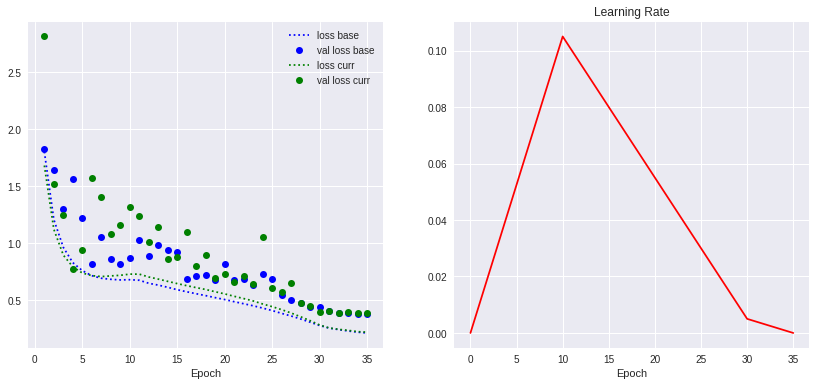

In [24]:
x_ = np.arange(1,turbo.epochs()+1)
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(x_, hist.history['loss'],'b:',label='loss base')
ax[0].plot(x_, hist.history['val_loss'],'bo',label='val loss base')
ax[0].plot(x_, hist2.history['loss'],'g:',label='loss curr')
ax[0].plot(x_, hist2.history['val_loss'],'go',label='val loss curr')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_yscale('log')
x_ = np.arange(turbo.epochs()+1)
ax[1].plot(x_, turbo.lr_schedule(x_*BATCHES_PER_EPOCH),'r-')
ax[1].set_title('Learning Rate')
ax[1].set_xlabel('Epoch')

plt.show()

### Store Performance Data and Update Generator

In [25]:
curr2_opt = np.max(hist2.history['val_acc'])
print(it.send(curr2_opt))
perf[curr2] = curr2_opt

print('\n\nCurrent Best: ',max((perf[k],k) for k in perf))
print('Last Candidate: ',(perf[curr2],curr2))

if curr2_opt > curr_opt:
  curr_opt = curr2_opt
  curr = curr2
  hist = hist2
  model.save_weights(model_type+'_weights_best.h5')

Not Improved


Current Best:  (0.9269, (0, 0, 0))
Last Candidate:  (0.9236, (1, 0, 0))


## [go to: Generate New Parameter Combination](#scrollTo=--pJ524MuGbf)

In [26]:
tmp = pd.DataFrame([[get_params(k)[p] for p in ['lr','rho','alpha']]+[v] for k,v in perf.items()], 
             columns=['lambda','rho','alpha','accuracy']).sort_values('accuracy')
tmp.style.bar()

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:939: RuntimeWarning: divide by zero encountered in double_scalars
  zero_normed = width * (0 - s.min()) / (s.max() - s.min())


,lambda,rho,alpha,accuracy
1,0.105,0.93,0.00015,0.9236
0,0.07,0.93,0.00015,0.9269
